# Mixed-precision quantization of SpeechBrain CRDNN on GPU


This notebook provides code for mixed-precision quantization of the speechbrain/asr-crdnn-rnnlm-librispeech model. We compare base model and different mixed-precision quantized models on the timit_asr dataset.

First, let's install `datasets`,  `transformers` and `librosa`.

In [ ]:
# # %%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install jiwer
!pip install librosa

In [2]:
device = 'cuda'

Next, we install `TensorRT` from source to use its tool `pytorch-quantization` for GPU quantization.

In [3]:
# ! git clone https://github.com/NVIDIA/TensorRT.git

In [4]:
# ! cd TensorRT/tools/pytorch-quantization && pip install .

In [5]:
# ! pip install --upgrade tensorrt

## Prepare Data, Tokenizer, Feature Extractor

In [ ]:
from datasets import load_dataset, load_metric
timit = load_dataset("timit_asr")

In [7]:
timit = timit.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

We normalize the text to only have lower case letters and append a word separator token at the end.

In [8]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [ ]:
timit = timit.map(remove_special_characters)

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.

In [10]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [11]:
vocabs = timit.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=timit.column_names["train"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [12]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [13]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

We also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm.

In [14]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [15]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)

Let's now save the vocabulary as a json file.

In [16]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [17]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

### Create Wav2Vec2 Feature Extractor

In [18]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

In [19]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Let's apply the data preparation function to all examples.

In [20]:
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [ ]:
timit = timit.map(prepare_dataset, remove_columns=timit.column_names["train"], num_proc=4)

In [22]:
max_input_length_in_sec = 4.0
timit["train"] = timit["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

  0%|          | 0/5 [00:00<?, ?ba/s]

## Base Model

In [25]:
from speechbrain.pretrained import EncoderDecoderASR
import torch

In [32]:
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [63]:
with torch.no_grad():
    features = asr_model.mods.encoder.compute_features(torch.tensor(timit["train"][:1]["input_values"]).cuda())

In [ ]:
torch.onnx.export(asr_model.mods.encoder.model,
     args=features.cuda(),
     f="asr-crdnn-encoder.onnx",
     export_params=True,
     opset_version=17,
     do_constant_folding=True,
     input_names = ['modelInput'],
     output_names = ['modelOutput'],
     dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
     'modelOutput' : {0 : 'batch_size'}}
)

## Mixed-precision Quantization

In [26]:
import pytorch_quantization
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib

In [27]:
eight_bits_all_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})
four_bits_all_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})
four_bits_cnn_eight_bits_dnn_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})
eight_bits_cnn_four_bits_dnn_model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [28]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [29]:
quant_modules.initialize()
eight_bits_all_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [30]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=4, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [31]:
quant_modules.initialize()
four_bits_all_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [32]:
quant_desc_input_4bits = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_desc_input_8bits = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight_4bits = QuantDescriptor(num_bits=4, axis=(0))
quant_desc_weight_8bits = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input_4bits)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight_4bits)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input_8bits)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight_8bits)

In [33]:
quant_modules.initialize()
four_bits_cnn_eight_bits_dnn_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [34]:
quant_desc_input_4bits = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_desc_input_8bits = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight_4bits = QuantDescriptor(num_bits=4, axis=(0))
quant_desc_weight_8bits = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input_8bits)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight_8bits)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input_4bits)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight_4bits)

In [35]:
quant_modules.initialize()
eight_bits_cnn_four_bits_dnn_model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [36]:
for name, module in eight_bits_all_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant() 

In [37]:
for name, module in four_bits_all_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant() 

In [38]:
for name, module in four_bits_cnn_eight_bits_dnn_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant() 

In [39]:
for name, module in eight_bits_cnn_four_bits_dnn_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant() 

In [ ]:
import torch
with torch.no_grad():
    for i in range(2000):
            _ = eight_bits_all_model_full_quantized(torch.tensor(timit["train"][i:i+1]["input_values"]).cuda(), torch.tensor([1.0]).to('cuda'))
            _ = four_bits_all_model_full_quantized(torch.tensor(timit["train"][i:i+1]["input_values"]).cuda(), torch.tensor([1.0]).to('cuda'))
            _ = four_bits_cnn_eight_bits_dnn_model_full_quantized(torch.tensor(timit["train"][i:i+1]["input_values"]).cuda(), torch.tensor([1.0]).to('cuda'))
            _ = eight_bits_cnn_four_bits_dnn_model_full_quantized(torch.tensor(timit["train"][i:i+1]["input_values"]).cuda(), torch.tensor([1.0]).to('cuda'))

In [41]:
# Finalize calibration

for name, module in eight_bits_all_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.load_calib_amax()
        module.disable_calib()
        module.enable_quant()

eight_bits_all_model_full_quantized.cuda()

W1226 16:13:47.546217 140714843820032 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([128, 1, 1, 1]).
W1226 16:13:47.547989 140714843820032 tensor_quantizer.py:239] Call .cuda() if running on GPU after loading calibrated amax.
W1226 16:13:47.548639 140714843820032 tensor_quantizer.py:174] Disable MaxCalibrator
W1226 16:13:47.549181 140714843820032 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([128, 1, 1, 1]).
W1226 16:13:47.549781 140714843820032 tensor_quantizer.py:174] Disable MaxCalibrator
W1226 16:13:47.550222 140714843820032 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([256, 1, 1, 1]).
W1226 16:13:47.550737 140714843820032 tensor_quantizer.py:174] Disable MaxCalibrator
W1226 16:13:47.551102 140714843820032 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([256, 1, 1, 1]).
W1226 16:13:47.551476 140714843820032 tensor_quantizer.py:174] Disable MaxCalibrator
W1226 16:13:47.551915 140714843820032 tensor_quantizer.py:2

EncoderDecoderASR(
  (mods): ModuleDict(
    (normalizer): InputNormalization()
    (encoder): LengthsCapableSequential(
      (compute_features): Fbank(
        (compute_STFT): STFT()
        (compute_fbanks): Filterbank()
        (compute_deltas): Deltas()
        (context_window): ContextWindow()
      )
      (normalize): InputNormalization()
      (model): CRDNN(
        (CNN): Sequential(
          (block_0): CNN_Block(
            (conv_1): Conv2d(
              (conv): QuantConv2d(
                1, 128, kernel_size=(3, 3), stride=(1, 1)
                (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=[0.1787, 0.7642](128) calibrator=MaxCalibrator scale=1.0 quant)
              )
            )
            (norm_1): LayerNorm(
              (norm): LayerNorm((40, 128), eps=1e-05, elementwise_affine=True)
            )
            (act_1): Lea

In [ ]:
for name, module in four_bits_all_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.load_calib_amax()
        module.disable_calib()
        module.enable_quant()

four_bits_all_model_full_quantized.cuda()

In [ ]:
for name, module in four_bits_cnn_eight_bits_dnn_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.load_calib_amax()
        module.disable_calib()
        module.enable_quant()

four_bits_cnn_eight_bits_dnn_model_full_quantized.cuda()

In [ ]:
for name, module in eight_bits_cnn_four_bits_dnn_model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.load_calib_amax()
        module.disable_calib()
        module.enable_quant()

eight_bits_cnn_four_bits_dnn_model_full_quantized.cuda()

In [45]:
eight_bits_all_model_full_quantized.mods.encoder.model.DNN = eight_bits_all_model_full_quantized.mods.encoder.model.DNN 
eight_bits_all_model_full_quantized.mods.encoder.model.CNN = eight_bits_all_model_full_quantized.mods.encoder.model.CNN 

four_bits_all_model_quantized.mods.encoder.model.DNN = four_bits_all_model_full_quantized.mods.encoder.model.DNN 
four_bits_all_model_quantized.mods.encoder.model.CNN = four_bits_all_model_full_quantized.mods.encoder.model.CNN

four_bits_cnn_eight_bits_dnn_model_quantized.mods.encoder.model.DNN = four_bits_cnn_eight_bits_dnn_model_full_quantized.mods.encoder.model.DNN 
four_bits_cnn_eight_bits_dnn_model_quantized.mods.encoder.model.CNN = four_bits_cnn_eight_bits_dnn_model_full_quantized.mods.encoder.model.CNN

eight_bits_cnn_four_bits_dnn_model_quantized.mods.encoder.model.DNN = eight_bits_cnn_four_bits_dnn_model_full_quantized.mods.encoder.model.DNN 
eight_bits_cnn_four_bits_dnn_model_quantized.mods.encoder.model.CNN = eight_bits_cnn_four_bits_dnn_model_full_quantized.mods.encoder.model.CNN 


In [ ]:
torch.onnx.export(eight_bits_all_model_quantized.mods.encoder.model,
             args=features.cuda(),
             f="asr-crdnn-encoder-eight_bits_all_model_quantized.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [ ]:
torch.onnx.export(four_bits_all_model_quantized.mods.encoder.model,
             args=features.cuda(),
             f="asr-crdnn-encoder-four_bits_all_model_quantized.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [48]:
torch.onnx.export(four_bits_cnn_eight_bits_dnn_model_quantized.mods.encoder.model,
             args=features.cuda(),
             f="asr-crdnn-encoder-four_bits_cnn_eight_bits_dnn_model_quantized.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [49]:
torch.onnx.export(eight_bits_cnn_four_bits_dnn_model_quantized.mods.encoder.model,
             args=features.cuda(),
             f="asr-crdnn-encoder-eight_bits_cnn_four_bits_dnn_model_quantized.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

### Base vs Quantized Models Inference Time

In this section, we compare the inference time of the base model and the quantized models on the test data. Furthermore, we evalute the perfomance of the base and the quantized models using the word error rate (WER) metric.

**Inference**

In [ ]:
# ! pip install onnxruntime-gpu

In [28]:
import onnxruntime as ort
import tensorrt
ort.get_device()

'GPU'

In [65]:
# Load onnx models
ort_sess_eight_bits_all_model_quantized = ort.InferenceSession('asr-crdnn-encoder-eight_bits_all_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_four_bits_all_model_quantized = ort.InferenceSession('asr-crdnn-encoder-four_bits_all_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_four_bits_cnn_eight_bits_dnn_model_quantized = ort.InferenceSession('asr-crdnn-encoder-four_bits_cnn_eight_bits_dnn_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_eight_bits_cnn_four_bits_dnn_model_quantized = ort.InferenceSession('asr-crdnn-encoder-eight_bits_cnn_four_bits_dnn_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_base = ort.InferenceSession('asr-crdnn-encoder.onnx')

In [66]:
import time
import numpy 

def compute_inference_time(ort_sess, num_samples):
    model_time = 0
    with torch.no_grad():
        for single_batch in timit["test"].select(range(num_samples)):
            initial_input = torch.tensor([single_batch["input_values"]]).cuda()
            features_input = asr_model.mods.encoder.compute_features(initial_input)
            input_values = torch.tensor(features_input, device="cpu")
            input_values = input_values.clone().detach().numpy().astype(numpy.float32)
            starttime = time.time()
            ort_sess.run(['modelOutput'], {'modelInput': input_values})
            model_time += time.time() - starttime
    return round(model_time/num_samples, 8)

In [ ]:
num_samples = 500

base_model_time = compute_inference_time(ort_sess_base, num_samples)

In [68]:
print(f'Base Model inference time {base_model_time} seconds')

Base Model inference time 0.17237618 seconds


In [ ]:
ort_sess_eight_bits_all_model_quantized_time = compute_inference_time(ort_sess_eight_bits_all_model_quantized, num_samples)

In [53]:
print(f'Quantized Model, all layers with 8 bits, inference time {ort_sess_eight_bits_all_model_quantized_time} seconds')

Quantized Model, all layers with 8 bits, inference time 0.01828577 seconds


In [ ]:
ort_sess_four_bits_all_model_quantized_time = compute_inference_time(ort_sess_four_bits_all_model_quantized, num_samples)

In [55]:
print(f'Quantized Model, all layers with 4 bits, inference time {ort_sess_four_bits_all_model_quantized_time} seconds')

Quantized Model, all layers with 4 bits, inference time 0.01824437 seconds


In [ ]:
ort_sess_four_bits_cnn_eight_bits_dnn_model_quantized_time = compute_inference_time(ort_sess_four_bits_cnn_eight_bits_dnn_model_quantized, num_samples)

In [57]:
print(f'Quantized Model, 4 bits cnn and 8 bits dnn, inference time {ort_sess_four_bits_cnn_eight_bits_dnn_model_quantized_time} seconds')

Quantized Model, 4 bits cnn and 8 bits dnn, inference time 0.01819254 seconds


In [ ]:
ort_sess_eight_bits_cnn_four_bits_dnn_model_quantized_time = compute_inference_time(ort_sess_eight_bits_cnn_four_bits_dnn_model_quantized, num_samples)

In [59]:
print(f'Quantized Model, 8 bits cnn and 4 bits dnn, inference time {ort_sess_eight_bits_cnn_four_bits_dnn_model_quantized_time} seconds')

Quantized Model, 8 bits cnn and 4 bits dnn, inference time 0.01820788 seconds


**Inference Time Visualisation of Results**

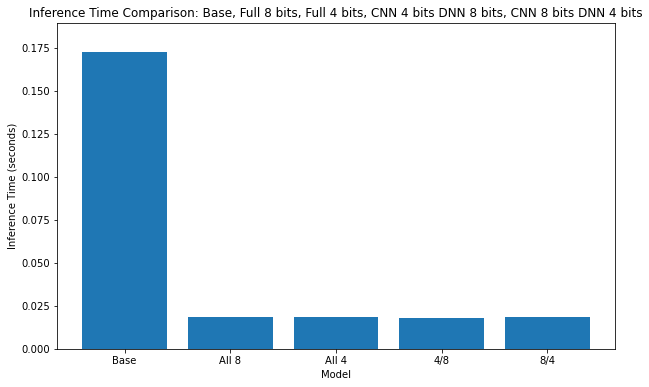

In [69]:
import matplotlib.pyplot as plt

models = ['Base', 'All 8', 'All 4', '4/8', '8/4']
inference_times = [base_model_time, ort_sess_eight_bits_all_model_quantized_time, ort_sess_four_bits_all_model_quantized_time, ort_sess_four_bits_cnn_eight_bits_dnn_model_quantized_time, ort_sess_eight_bits_cnn_four_bits_dnn_model_quantized_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base, Full 8 bits, Full 4 bits, CNN 4 bits DNN 8 bits, CNN 8 bits DNN 4 bits')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

**Evaluating WER metric**

In [52]:
wer_metric = load_metric("wer")

Downloading:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

In [62]:
def map_model_to_wer_result(model, single_batch):
    input_values = torch.tensor(single_batch["input_values"]).to('cuda')
    with torch.no_grad():
        prediction = model(input_values, torch.tensor([1.0]).to('cuda'))
    
    pred_str = [' '.join(prediction[0]).lower()]
    correct_str = processor.batch_decode(single_batch['labels'], group_tokens=False)
    return wer_metric.compute(predictions=pred_str, references=correct_str)

In [54]:
num_samples = 500

In [ ]:
total_wer = 0

for i in range(num_samples):
    total_wer += map_model_to_wer_result(asr_model, timit['test'][i:i+1])
    
base_wer_result = round(total_wer / num_samples, 8)

In [56]:
print(f'Base Model WER: {base_wer_result}')

Base Model WER: 0.16773638


In [63]:
total_wer_eight_bits_all_model_quantized = 0

for i in range(num_samples):
    total_wer_eight_bits_all_model_quantized += map_model_to_wer_result(eight_bits_all_model_quantized, timit['test'][i:i+1])
    
eight_bits_all_model_quantized_wer_result = round(total_wer_eight_bits_all_model_quantized / num_samples, 8)

In [64]:
print(f'Quantized Model, all layers with 8 bits, WER: {eight_bits_all_model_quantized_wer_result}')

Quantized Model, all layers with 8 bits, WER: 0.16773638


In [65]:
total_wer_four_bits_all_model_quantized = 0

for i in range(num_samples):
    total_wer_four_bits_all_model_quantized += map_model_to_wer_result(four_bits_all_model_quantized, timit['test'][i:i+1])
    
total_wer_four_bits_all_model_quantized_wer_result = round(total_wer_four_bits_all_model_quantized / num_samples, 8)

In [66]:
print(f'Quantized Model, all layers with 4 bits, WER: {total_wer_four_bits_all_model_quantized_wer_result}')

Quantized Model, all layers with 4 bits, WER: 0.1676834


In [68]:
total_four_bits_cnn_eight_bits_dnn_model_quantized = 0

for i in range(num_samples):
    total_four_bits_cnn_eight_bits_dnn_model_quantized += map_model_to_wer_result(four_bits_cnn_eight_bits_dnn_model_quantized, timit['test'][i:i+1])
    
four_bits_cnn_eight_bits_dnn_model_quantized_wer_result = round(total_four_bits_cnn_eight_bits_dnn_model_quantized / num_samples, 8)

In [69]:
print(f'Quantized Model, 4 bits CNN and 8 bits DNN, WER: {four_bits_cnn_eight_bits_dnn_model_quantized_wer_result}')

Quantized Model, 4 bits CNN and 8 bits DNN, WER: 0.1769932


In [70]:
total_eight_bits_cnn_four_bits_dnn_model_quantized = 0

for i in range(num_samples):
    total_eight_bits_cnn_four_bits_dnn_model_quantized += map_model_to_wer_result(eight_bits_cnn_four_bits_dnn_model_quantized, timit['test'][i:i+1])
    
eight_bits_cnn_four_bits_dnn_model_quantized_wer_result = round(total_eight_bits_cnn_four_bits_dnn_model_quantized / num_samples, 8)

In [71]:
print(f'Quantized Model, 8 bits CNN and 4 bits DNN, WER: {eight_bits_cnn_four_bits_dnn_model_quantized_wer_result}')

Quantized Model, 8 bits CNN and 4 bits DNN, WER: 0.1676834


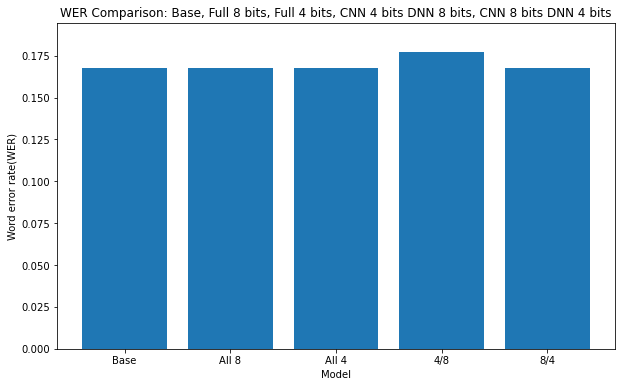

In [72]:
import matplotlib.pyplot as plt

models = ['Base', 'All 8', 'All 4', '4/8', '8/4']
inference_times = [base_wer_result, eight_bits_all_model_quantized_wer_result, total_wer_four_bits_all_model_quantized_wer_result, four_bits_cnn_eight_bits_dnn_model_quantized_wer_result, eight_bits_cnn_four_bits_dnn_model_quantized_wer_result]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Word error rate(WER)')
plt.title('WER Comparison: Base, Full 8 bits, Full 4 bits, CNN 4 bits DNN 8 bits, CNN 8 bits DNN 4 bits')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()